<a href="https://colab.research.google.com/github/hijera/NN_colab_hw/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%C2%AB%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B5%C2%BB_(%D0%92%D0%BB%D0%B0%D1%81%D0%BE%D0%B2_%D0%90%D0%BD%D1%82%D0%BE%D0%BD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

import keras
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

print(tf.__version__)
print(tf.executing_eagerly())

2.14.0
True


## Функции загрузки данных

In [ ]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train_sample/*.jpg')
test_files = glob('data/test_sample/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

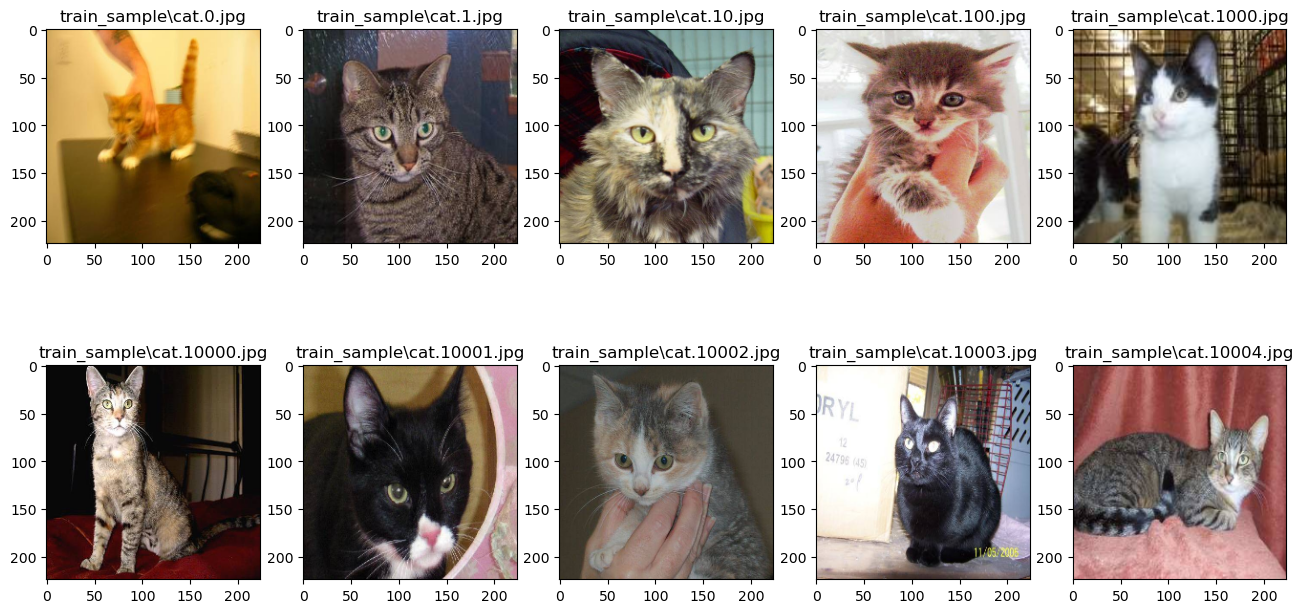

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Создаем  модель

In [ ]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
## фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
#x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Conv2D(128, (3, 3), activation='relu',  padding='same')(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Conv2D(128, (3, 3), activation='relu',  padding='same')(x)
x=tf.keras.layers.MaxPooling2D((2, 2))(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x=tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)


model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','log_loss'])




## Выводим архитектуру модели

In [ ]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
val_samples = 128  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=20,  # число вызовов генератора за эпоху
          epochs=20,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/20
20/20 [==============================] - 24s 1s/step - loss: 149.3336 - accuracy: 0.5297 - val_loss: 3.1335 - val_accuracy: 0.6484
Epoch 2/20
20/20 [==============================] - 23s 1s/step - loss: 4.8750 - accuracy: 0.6922 - val_loss: 1.8033 - val_accuracy: 0.7656
Epoch 3/20
20/20 [==============================] - 23s 1s/step - loss: 2.2857 - accuracy: 0.7703 - val_loss: 0.8138 - val_accuracy: 0.8281
Epoch 4/20
20/20 [==============================] - 23s 1s/step - loss: 1.5553 - accuracy: 0.8297 - val_loss: 0.5490 - val_accuracy: 0.8750
Epoch 5/20
20/20 [==============================] - 23s 1s/step - loss: 0.9113 - accuracy: 0.8844 - val_loss: 0.3705 - val_accuracy: 0.9141
Epoch 6/20
20/20 [==============================] - 23s 1s/step - loss: 0.7724 - accuracy: 0.8953 - val_loss: 0.4322 - val_accuracy: 0.8984
Epoch 7/20
20/20 [==============================] - 23s 1s/step - loss: 0.7412 - accuracy: 0.8938 - val_loss: 0.2768 - val_accuracy: 0.9141
Epoch 8/20
20/20 [

In [ ]:
model.save('cats-dogs-vgg16-custom.hdf5')

C:\Users\Антон\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Предсказания на проверочной выборке

In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 479s 38ms/step


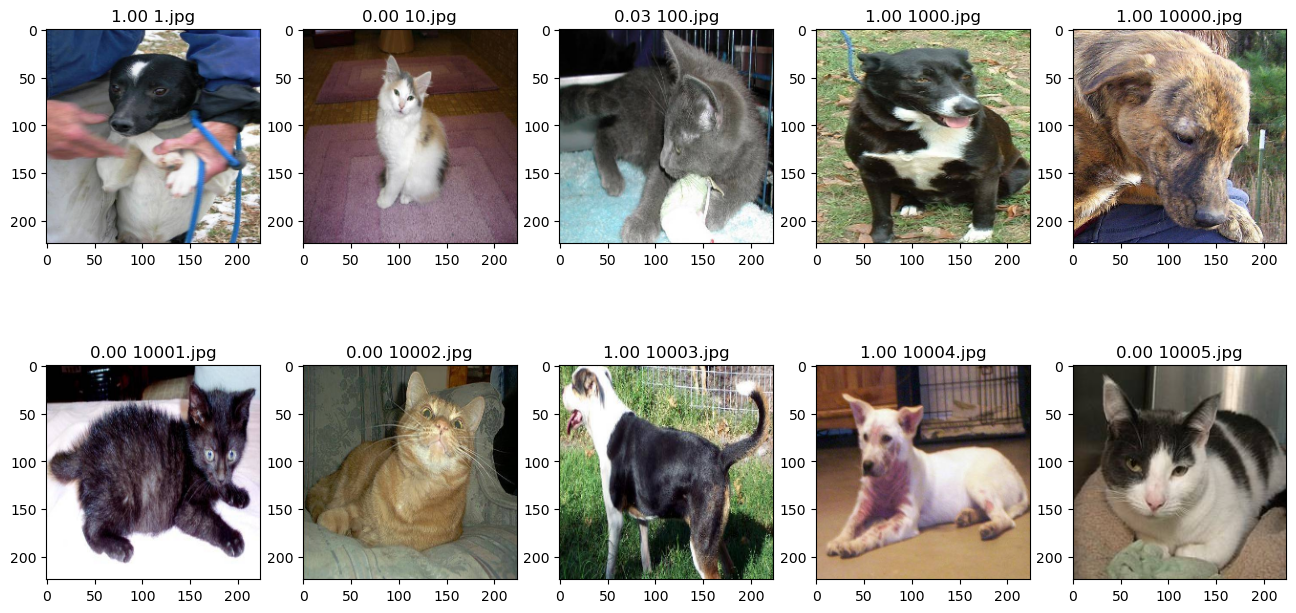

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [ ]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 0.22158